In [2]:
import numpy as np
import cv2 as cv

In [3]:
from ProjectPaths import ProjectPaths

ProjectPaths.instance(r"/home/tdjg/Documents/DeepSolaris")

In [4]:
mask_images = np.load(ProjectPaths.instance().file_in_image_dir("ds_image_masks.npy"))

In [5]:
images = np.load(ProjectPaths.instance().file_in_image_dir("ds_images.npy"))
images[0].shape

(75, 75, 3)

In [6]:
def avg_image(image):
    avg_kernel = np.ones((3,3), dtype=np.float32)
    avg_kernel /= 9
    return cv.filter2D(image, -1, avg_kernel)

In [7]:
def window_locations(r=2):
    x = [-r, 0, r]
    y = [-r, 0, r]
    mask = np.zeros((1+2*r,1+2*r))
    
    for xc in x:
        for yc in y:
            mask[r + yc, r + xc] = 1.0
    return np.tile(mask,(3,1,1)).T
    
window_mask = window_locations()

In [8]:
def extract_features(image, r=2):
    #grab the spatial dimensions of the image, along with
    # the spatial dimensions of the kernel
    (iH, iW) = image.shape[:2]
    
    kernel = window_locations(r)
    (kH, kW) = kernel.shape[:2]

    # allocate memory for the output image, taking care to
    # "pad" the borders of the input image so the spatial
    # size (i.e., width and height) are not reduced
    pad = (kW - 1) // 2
    image = cv.copyMakeBorder(image, pad, pad, pad, pad, cv.BORDER_REPLICATE)
    output = np.zeros((iH, iW, 27), dtype="float32")
    # loop over the input image, "sliding" the kernel across
    # each (x, y)-coordinate from left-to-right and top to
    # bottom
    for y in np.arange(pad, iH + pad):
        for x in np.arange(pad, iW + pad):
            # extract the ROI of the image by extracting the
            # *center* region of the current (x, y)-coordinates
            # dimensions
            roi = image[y - pad:y + pad + 1, x - pad:x + pad + 1]

            # perform the actual selection by taking the
            # element-wise multiplicate between the ROI and
            # the kernel
            k = (roi * kernel)

            # store the convolved value in the output (x,y)-
            # coordinate of the output image
            output[y - pad, x - pad, :] = k[np.nonzero(kernel)]
    
    # return the output image
    return output

In [9]:
from scipy import ndimage

def std_image(image):
    average = avg_image(image)
    x2_min_avg = (image - average) * (image - average);
    avg_kernel_3d = np.ones((3, 3, 3), dtype=np.float32)
    avg_kernel_3d /= 9
    conv_image = ndimage.convolve(x2_min_avg, avg_kernel_3d, np.float32) 
    return np.sqrt(conv_image)

In [10]:
def normalize_image(image):
    return (image - image.min()) / (image.max() - image.min())


In [11]:
std = std_image(images[0])
import matplotlib.pyplot as plt
%matplotlib inline

std.dtype

dtype('float32')

In [12]:
def get_features(image):
    avg = avg_image(image)
    std = std_image(image)
    
    avg_output2 = extract_features(avg)
    std_output2 = extract_features(std)
    
    avg_output4 = extract_features(avg, 4)
    std_output4 = extract_features(std, 4)
    return np.concatenate((avg_output2, std_output2, avg_output4, std_output4), axis=2)

In [13]:
def get_features_for(images):
    feature_list = []
    for image in images:
        feature_list.append(get_features(image))
    return np.array(feature_list)

X = get_features_for(images)
X.shape

(120, 75, 75, 108)

In [14]:
pixel_features = X.reshape(120*75*75, 108)
pixel_features.shape

(675000, 108)

In [15]:
pixel_masks = mask_images.reshape(120*75*75)
pixel_masks.shape

(675000,)

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(pixel_features, pixel_masks, test_size = 0.20)

# Random Forest

In [96]:
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier()
clf.fit(X_train, y_train)

/home/tdjg/.virtualenvs/cv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [ ]:
clf.feature_importances_

In [88]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def predict(clf, X_test, y_test):
    predictions = clf.predict(X_test)
    print(classification_report(y_test, predictions))
    print("accuracy={}".format(accuracy_score(y_test, predictions)))
    print(confusion_matrix(y_test, predictions))

In [97]:
predict(clf, X_test, y_test)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     91687
         255       0.96      0.94      0.95     43313

   micro avg       0.97      0.97      0.97    135000
   macro avg       0.97      0.96      0.96    135000
weighted avg       0.97      0.97      0.97    135000

accuracy=0.9680592592592593
[[90027  1660]
 [ 2652 40661]]


In [33]:
im_features = get_features_for([images[-1]])
im_features = im_features.reshape(75*75, 108)

In [34]:
im_pred = clf.predict(im_features)
im_pred.shape

(5625,)

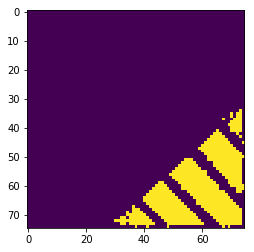

In [35]:
prediction_image = im_pred.reshape(75, 75)
plt.imshow(prediction_image)

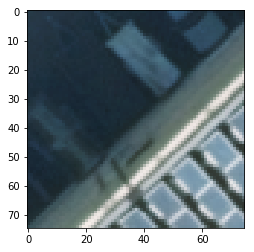

In [37]:
plt.imshow(images[-1][:,:,::-1])

In [1]:
from ProjectPaths import ProjectPaths
from Datasets import Datasets


ProjectPaths.instance(r"/home/tdjg/Documents/DeepSolaris")
ac_dataset = Datasets.datasets()["AcMüDüHo"]
train = ac_dataset[0].images

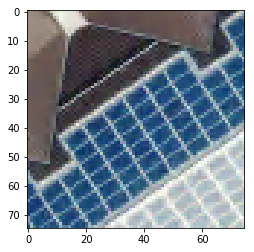

In [31]:
plt.imshow(train[8][:,:,::-1])

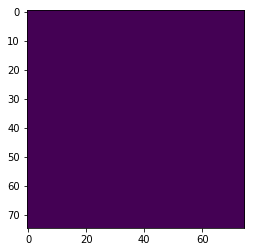

In [41]:
im_features2 = get_features_for([train[8]])
im_features2 = im_features2.reshape(75*75, 108)

im_pred = clf.predict(im_features2)
prediction_image = im_pred.reshape(75, 75)

plt.imshow(prediction_image)

# Logistic Regression

In [43]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, solver='lbfgs').fit(X_train, y_train)

/home/tdjg/.virtualenvs/cv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [46]:
predictions = clf.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90     91687
         255       0.79      0.81      0.80     43313

   micro avg       0.87      0.87      0.87    135000
   macro avg       0.85      0.85      0.85    135000
weighted avg       0.87      0.87      0.87    135000



In [47]:
accuracy_score(y_test, predictions)

0.8677481481481482

In [48]:
confusion_matrix(y_test, predictions)

array([[82158,  9529],
       [ 8325, 34988]])

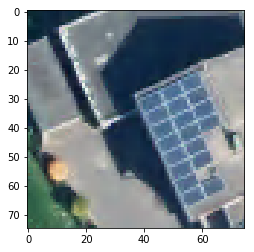

In [51]:
plt.imshow(train[1][:,:,::-1])

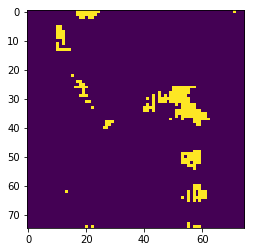

In [50]:
im_features3 = get_features_for([train[1]])
im_features3 = im_features3.reshape(75*75, 108)

im_pred = clf.predict(im_features3)
prediction_image = im_pred.reshape(75, 75)

plt.imshow(prediction_image)

# PCA

In [106]:
import math

def reorderMatrix(u):
    c1 = np.array([1/3 * math.sqrt(3) for _ in range(3)])
    c2 = np.array([1, -1, -1] * c1)
    c3 = np.array([0, -1/2 * math.sqrt(2), 1/2 * math.sqrt(2)])
    v1 = u.dot(c2)
    i1 = np.argmax(v1)
    v2 = u.dot(c3)
    i2 = np.argmax(v2)
    if i1 == 2 and i2 == 1:
        temp = u[i1]
        u[i1] =  u[i2]
        u[i2] = temp
    return u

def flattenImage(rgbImage):
    return rgbImage.reshape(rgbImage.shape[0] * rgbImage.shape[1], 3)

def imageMean(image):
    return (1 / image.size) * np.sum(image)

def centerImage(image):
    return image - imageMean(image)

def imageCovariance(image1, image2):
    return (1 / image1.size) * np.dot(centerImage(image1).ravel(), centerImage(image2).ravel())

def rgbImageCovarianceMatrix(rgbImage):
    covarianceMatrix = np.zeros([3,3])
    for r in range(3):
        for c in range (3):
            covariance = imageCovariance(rgbImage[:,:,r], rgbImage[:,:,c])
            covarianceMatrix[r, c] = covariance
            covarianceMatrix[c, r] = covariance
    return covarianceMatrix

def pca(rgbImage):
    covarianceMatrix = rgbImageCovarianceMatrix(rgbImage)
    return np.linalg.svd(covarianceMatrix)

def pcaTransform(rgbImage):
    u,s,v = pca(rgbImage)
    imageVector = flattenImage(rgbImage)
    transposedVector = imageVector.dot(reorderMatrix(u))
    return transposedVector.reshape(rgbImage.shape)

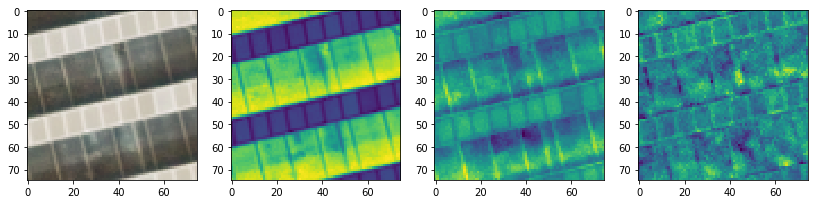

In [80]:
pca_image = pcaTransform(images[0])

_, ax = plt.subplots(1,4,figsize=(14,14))
ax[0].imshow(images[0])
ax[1].imshow(normalize_image(pca_image)[:,:,0])
ax[2].imshow(normalize_image(pca_image)[:,:,1])
ax[3].imshow(normalize_image(pca_image)[:,:,2])

In [81]:
pca_images = np.array([pcaTransform(image) for image in images])
pca_images.shape

(120, 75, 75, 3)

In [85]:
pca_features = get_features_for(pca_images)
pca_pixel_features = pca_features.reshape(120*75*75, 108)
pca_pixel_features.shape

(675000, 108)

In [86]:
pca_X_train, pca_X_test, pca_y_train, pca_y_test = train_test_split(pca_pixel_features, pixel_masks, test_size = 0.20)

In [103]:
clf = RandomForestClassifier()
clf.fit(pca_X_train, pca_y_train)

/home/tdjg/.virtualenvs/cv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [104]:
predict(clf, pca_X_test, pca_y_test)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     91735
         255       0.96      0.95      0.95     43265

   micro avg       0.97      0.97      0.97    135000
   macro avg       0.97      0.96      0.97    135000
weighted avg       0.97      0.97      0.97    135000

accuracy=0.9707629629629629
[[90052  1683]
 [ 2264 41001]]


In [98]:
from sklearn.decomposition import PCA

X = images[0].reshape(75*75,3)

pca = PCA()
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [99]:
pca.explained_variance_

array([9.52371198e+03, 2.39079106e+01, 3.16040148e+00])

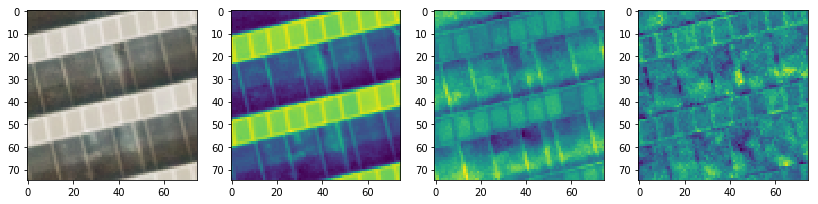

In [102]:
im_pca = pca.transform(X).reshape(75,75,3)

_, ax = plt.subplots(1,4,figsize=(14,14))
ax[0].imshow(images[0])
ax[1].imshow(normalize_image(im_pca)[:,:,0])
ax[2].imshow(normalize_image(im_pca)[:,:,1])
ax[3].imshow(normalize_image(im_pca)[:,:,2])

In [107]:
ac_pca_images = np.array([pcaTransform(image) for image in ac_dataset[0].images])
ac_pca_images.shape

(3357, 75, 75, 3)

In [ ]:
ac_pca_features = get_features_for(ac_pca_images)
ac_pca_pixel_features = ac_pca_features.reshape(120*75*75, 108)
ac_pca_pixel_features.shape

In [ ]:
predict(clf, ac_pca_features, ac_dataset[0].labels)